In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/M3Monthly_Cleaned_Sample.csv")
df["ds"] = pd.to_datetime(df["ds"])

In [3]:
sequence_length = 12
forecast_horizon = 12
results = []

In [4]:
def create_sequences(data, seq_len, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - seq_len - forecast_horizon):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+forecast_horizon])
    return np.array(X), np.array(y)

In [5]:
def build_model(seq_len):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(seq_len, 1)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(forecast_horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
for uid in df["unique_id"].unique():
    series = df[df["unique_id"] == uid].sort_values("ds")
    y_values = series["y"].values

    min_val, max_val = y_values.min(), y_values.max()
    y_scaled = (y_values - min_val) / (max_val - min_val + 1e-8)

    X, y = create_sequences(y_scaled, sequence_length, forecast_horizon)
    if len(X) == 0: continue

    X = X[..., np.newaxis]

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = build_model(sequence_length)
    model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=0)

    y_pred = model.predict(X_test)

    y_test_inv = y_test * (max_val - min_val) + min_val
    y_pred_inv = y_pred * (max_val - min_val) + min_val

    rmse = np.sqrt(np.mean((y_test_inv.flatten() - y_pred_inv.flatten())**2))
    mae = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())

    results.append({
        "unique_id": uid,
        "rmse": rmse,
        "mae": mae,
        "y_true": y_test_inv.flatten(),
        "y_pred": y_pred_inv.flatten()
    })

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


In [7]:
results_df = pd.DataFrame(results)
print(results_df[["unique_id", "rmse", "mae"]])

  unique_id       rmse        mae
0  M3M_0001  48.072139  41.953786
1  M3M_0002  44.079484  36.874921
2  M3M_0003  40.288345  33.937581


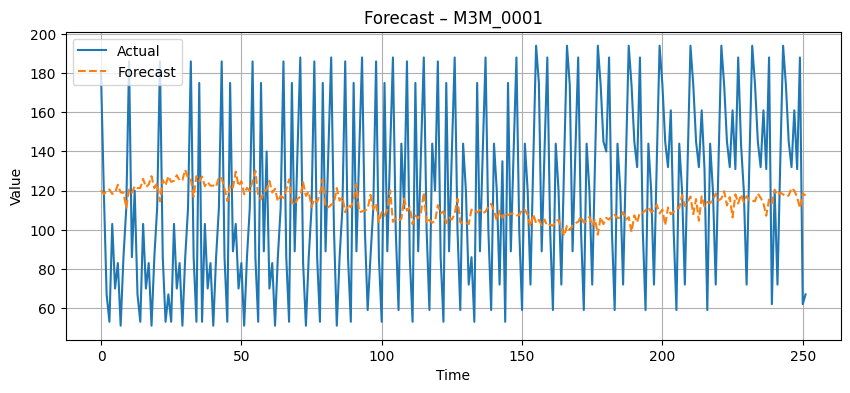

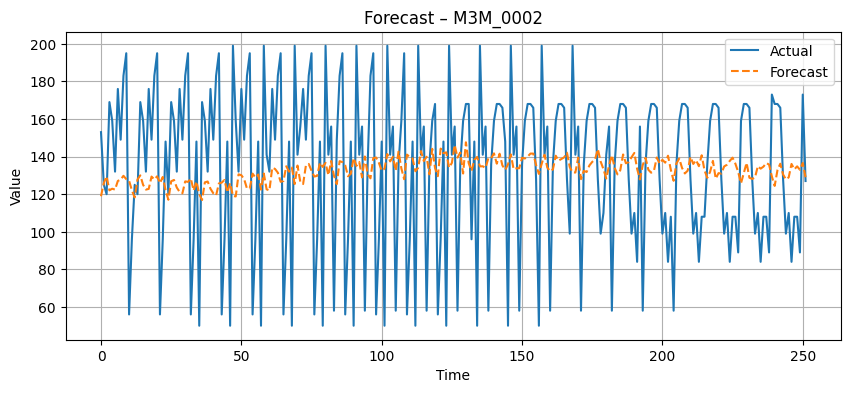

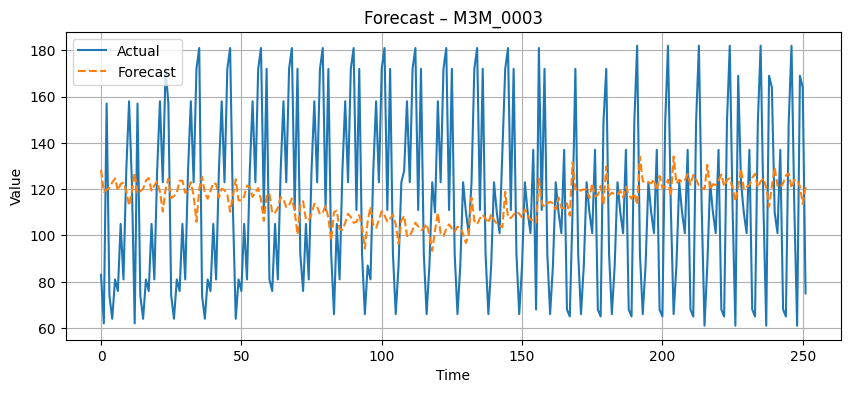

In [8]:
for r in results[:3]:
    plt.figure(figsize=(10, 4))
    plt.plot(r["y_true"], label="Actual")
    plt.plot(r["y_pred"], label="Forecast", linestyle="--")
    plt.title(f"Forecast – {r['unique_id']}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

##### Initialize results list

In [10]:
import pandas as pd

m3_monthly = pd.read_csv('/content/M3Monthly_Cleaned_Sample.csv')

print(m3_monthly.head())
print(m3_monthly.columns)

  unique_id          ds      y
0  M3M_0001  1990-01-01  141.0
1  M3M_0001  1990-02-01   64.0
2  M3M_0001  1990-03-01  117.0
3  M3M_0001  1990-04-01   81.0
4  M3M_0001  1990-05-01  103.0
Index(['unique_id', 'ds', 'y'], dtype='object')


In [11]:
results = []

for i, (uid, series) in enumerate(m3_monthly.groupby('unique_id')):
    values = series['y'].values.astype(np.float32)

    if len(values) < 2 * forecast_horizon:
        continue

    train, test = values[:-forecast_horizon], values[-forecast_horizon:]

    min_val, max_val = train.min(), train.max()
    train_norm = (train - min_val) / (max_val - min_val)
    test_norm = (test - min_val) / (max_val - min_val)

    def create_sequences(data, window_size=24):
        X, y = [], []
        for j in range(len(data) - window_size):
            X.append(data[j:j+window_size])
            y.append(data[j+window_size])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_norm)
    X_test, y_test = create_sequences(np.concatenate([train_norm[-24:], test_norm]))

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=15, verbose=0)

    y_pred = model.predict(X_test)

    y_test_inv = y_test * (max_val - min_val) + min_val
    y_pred_inv = y_pred.flatten() * (max_val - min_val) + min_val

    rmse = np.sqrt(np.mean((y_test_inv - y_pred_inv)**2))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)

    results.append({
        "unique_id": uid,
        "rmse": rmse,
        "mae": mae,
        "y_true": y_test_inv,
        "y_pred": y_pred_inv
    })

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


In [12]:
results_df = pd.DataFrame(results)
results_df[["unique_id", "rmse", "mae"]].to_csv("esrnn_m3_results.csv", index=False)

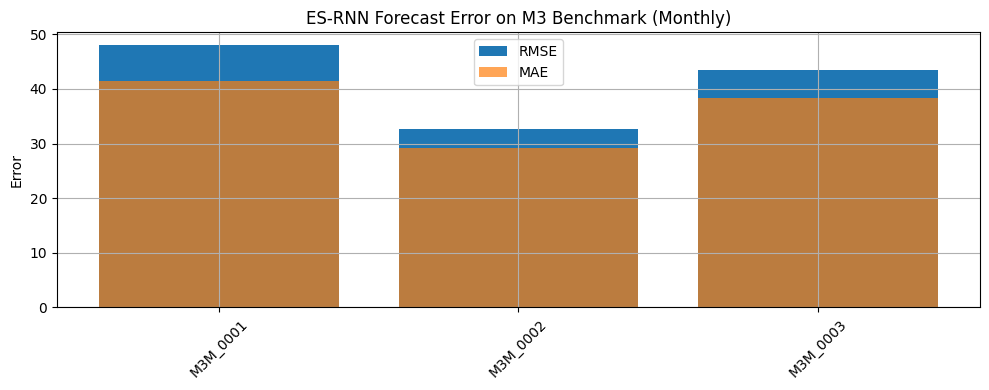

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(results_df['unique_id'], results_df['rmse'], label='RMSE')
plt.bar(results_df['unique_id'], results_df['mae'], label='MAE', alpha=0.7)
plt.ylabel('Error')
plt.title('ES-RNN Forecast Error on M3 Benchmark (Monthly)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

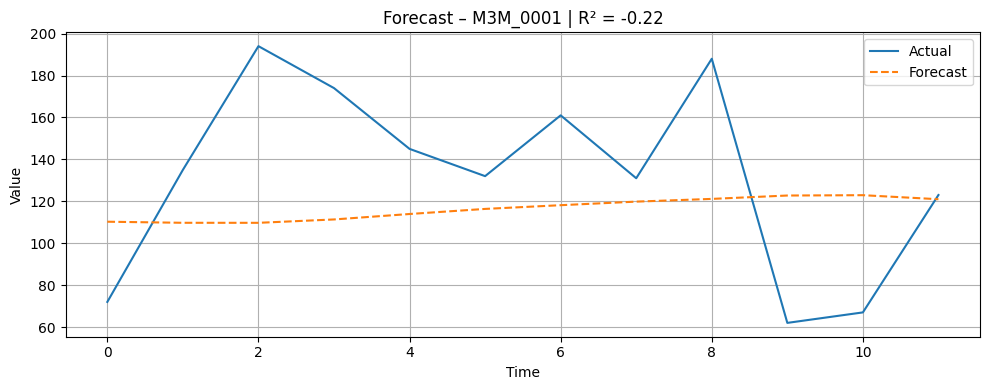

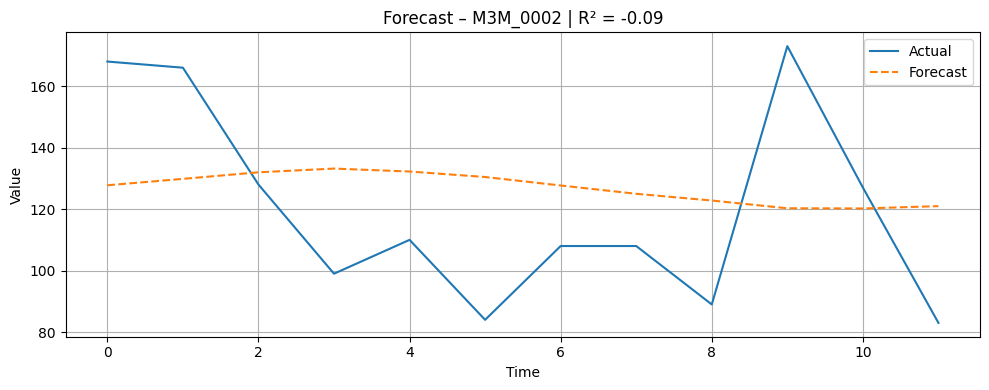

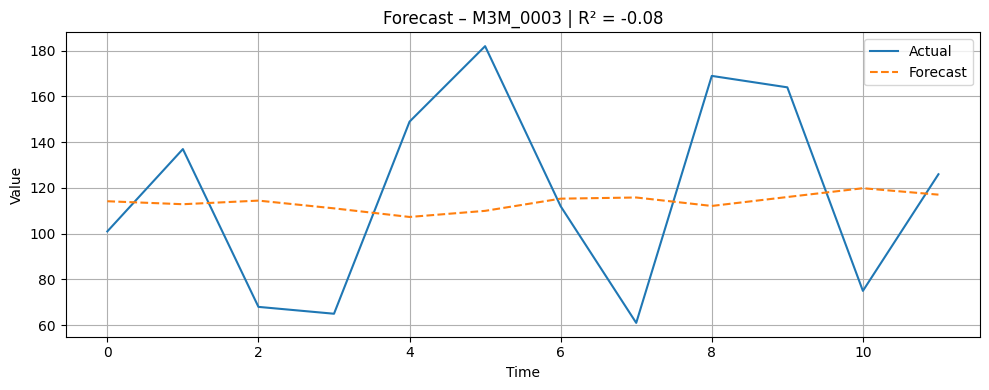

In [16]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

for r in results[:3]:
    y_true = r["y_true"]
    y_pred = r["y_pred"]
    r2 = r2_score(y_true, y_pred)

    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Forecast", linestyle="--")
    plt.title(f"Forecast – {r['unique_id']} | R² = {r2:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
results_df.to_csv("ESRNN_M3_Evaluation.csv", index=False)